In [2]:
import numpy as np
import pandas as pd

# dataset fetching
import openml
from ucimlrepo import fetch_ucirepo 

# model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score, classification_report, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint


# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# conformal prediction libraries
from venn_abers import VennAbersCalibrator, VennAbers


from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier

from mapie.regression import MapieTimeSeriesRegressor
from mapie.metrics import (regression_coverage_score,
                           coverage_width_based,
                           regression_mean_width_score,)
from mapie.subsample import BlockBootstrap


import warnings
warnings.filterwarnings('ignore')


# Medium Website Visit Dataset

,y,published,is_holiday,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_mean_3,y_std_3,y_mean_7,y_std_7,y_mean_30,y_std_30,hour,day,month,is_weekend
ds,,,,,,,,,,,,,,,,,,,,
2020-01-30,2568,0.0,0,2716.0,2917.0,2776.0,1870.0,1888.0,2184.0,2569.0,2733.666667,175.169442,2417.000000,432.901451,2133.600000,516.535114,0,30,1,0
2020-01-31,2288,0.0,0,2568.0,2716.0,2917.0,2776.0,1870.0,1888.0,2184.0,2524.000000,217.366051,2431.857143,425.289873,2172.166667,481.071296,0,31,1,0
2020-02-01,1640,0.0,0,2288.0,2568.0,2716.0,2917.0,2776.0,1870.0,1888.0,2165.333333,476.005602,2396.428571,484.372397,2168.033333,485.214029,0,1,2,1
2020-02-02,1842,0.0,0,1640.0,2288.0,2568.0,2716.0,2917.0,2776.0,1870.0,1923.333333,331.567992,2392.428571,489.532381,2172.800000,481.132672,0,2,2,1
2020-02-03,2918,0.0,0,1842.0,1640.0,2288.0,2568.0,2716.0,2917.0,2776.0,2133.333333,687.006065,2412.714286,510.566585,2226.000000,471.963105,0,3,2,0


,y,published,is_holiday,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_mean_3,y_std_3,y_mean_7,y_std_7,y_mean_30,y_std_30,hour,day,month,is_weekend
ds,,,,,,,,,,,,,,,,,,,,
2023-10-08,737,0.0,0,583.0,1030.0,1037.0,1136.0,1221.0,1176.0,665.0,783.333333,227.073410,988.571429,238.999900,1074.366667,277.338767,0,8,10,1
2023-10-09,1237,0.0,1,737.0,583.0,1030.0,1037.0,1136.0,1221.0,1176.0,852.333333,341.914219,997.285714,247.918477,1084.833333,277.354383,0,9,10,0
2023-10-10,1755,1.0,0,1237.0,737.0,583.0,1030.0,1037.0,1136.0,1221.0,1243.000000,509.026522,1073.571429,376.857116,1103.833333,302.808587,0,10,10,0
2023-10-11,3241,0.0,0,1755.0,1237.0,737.0,583.0,1030.0,1037.0,1136.0,2077.666667,1040.235230,1374.285714,904.891654,1159.200000,488.060228,0,11,10,0
2023-10-12,2262,0.0,0,3241.0,1755.0,1237.0,737.0,583.0,1030.0,1037.0,2419.333333,755.390186,1549.285714,946.297472,1187.866667,526.551680,0,12,10,0


2020-01-30 00:00:00 2023-10-12 00:00:00


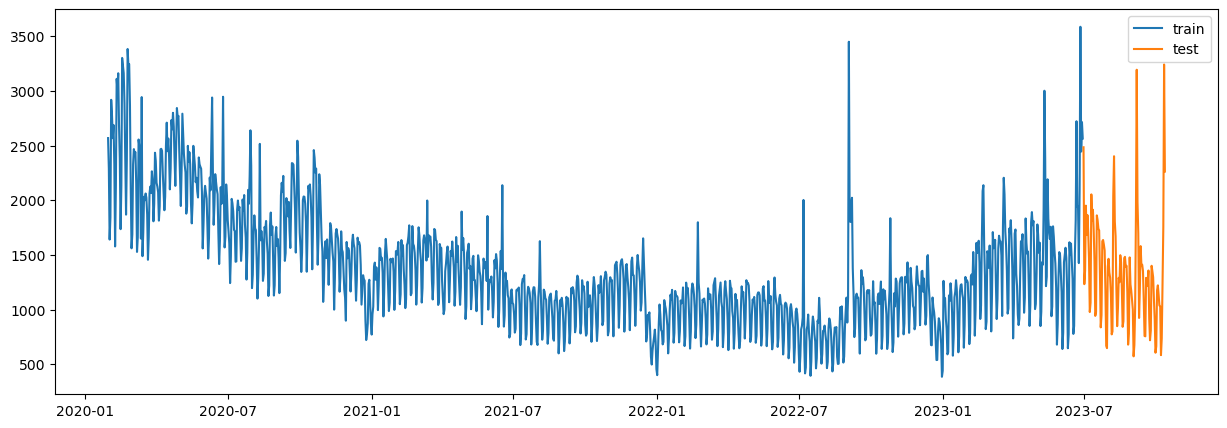

In [3]:
# data preparation

df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')

df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds')

# generate lag features - past readings to predict the future
n_lags = 7 # 7 days
for i in range(1, n_lags + 1):
    df[f'y_lag_{i}'] = df['y'].shift(i)

# generate rolling features
windows = [3, 7, 30]
for w in windows:
    df[f'y_mean_{w}'] = df['y'].rolling(window=w).mean()
    df[f'y_std_{w}'] = df['y'].rolling(window=w).std()

# generate time features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

# drop the rows with missing values
df.dropna(inplace=True)
df.drop(columns='unique_id', inplace=True)

display(df.head())
display(df.tail())

# print the time range
print(df.index.min(), df.index.max())

# train test split
train = df[df.index < '2023-06-30']
test = df[df.index >= '2023-06-30']
# split the features and target
X_train, y_train, X_test, y_test = train.drop(columns='y'), train[['y']], test.drop(columns='y'), test[['y']]

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['y'], label='train')
plt.plot(test.index, test['y'], label='test')
plt.legend()
plt.show()

## Model Training and Evaluation

In [4]:
# base model

# model = HistGradientBoostingRegressor(max_iter=200, max_depth=8, learning_rate=0.1, random_state=42)
# model.fit(X_train, y_train)

hgbr = HistGradientBoostingRegressor(random_state=42)
params = {
    "learning_rate":  ["squared_error", "absolute_error", "gamma"],
    "learning_rate": [0.1, 0.05, 0.001],
    "max_iter": [100, 150, 200],
    "min_samples_leaf": [1, 2, 3],
}

rand_search_cv = RandomizedSearchCV(
    hgbr,
    param_distributions=params,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

rand_search_cv.fit(X_train, y_train)
model = rand_search_cv.best_estimator_

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 133.71752614465487


##### Mapie

In [5]:
# parameter initialization

alpha = 0.05
gap = 1

cv_mapiets = BlockBootstrap(
    n_resamplings=9, n_blocks=9, overlapping=False, random_state=42
)

lower_clip_bound = y_train.min()
upper_clip_bound = y_train.max()

EnbPI without partial fitting
Coverage: 0.9523809523809523
Width: 652.2782755931321
CWC: 0.7555666545593817
R2 score: 0.8800241186904116


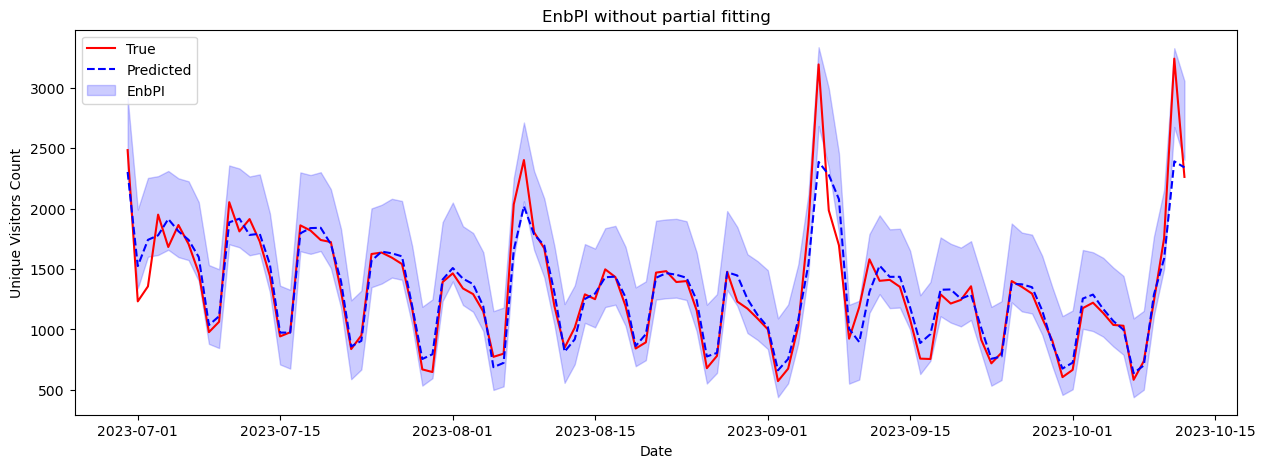

In [15]:
# For EnbPI without partial fitting
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=1
)
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_npfit, y_pis_enbpi_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)

# evaluation
coverage_enbpi_npfit = regression_coverage_score(
    y_test, y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
)
width_enbpi_npfit = regression_mean_width_score(
    y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
)
cwc_enbpi_pfit = coverage_width_based(
    y_test, y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0],
    eta=10,
    alpha=0.05
)
r2_enbpi_npfit = r2_score(y_test, y_pred_enbpi_npfit)
print(f"EnbPI without partial fitting")
print(f"Coverage: {coverage_enbpi_npfit}")
print(f"Width: {width_enbpi_npfit}")
print(f"CWC: {cwc_enbpi_pfit}")
print(f"R2 score: {r2_enbpi_npfit}")

# plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test.index, y_test, label="True", color="Red")
ax.plot(test.index, y_pred_enbpi_npfit, label="Predicted", color="blue", linestyle="--")
ax.fill_between(
    test.index,
    y_pis_enbpi_npfit[:, 0, 0],
    y_pis_enbpi_npfit[:, 1, 0],
    color="blue",
    alpha=0.2,
    label="EnbPI",
)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Unique Visitors Count")
ax.set_title("EnbPI without partial fitting")
plt.show()

EnbPI with partial fitting
Coverage: 0.9333333333333333
Width: 583.5647556503903
CWC: 0.7791871138580032
R2 score: 0.8800241186904116


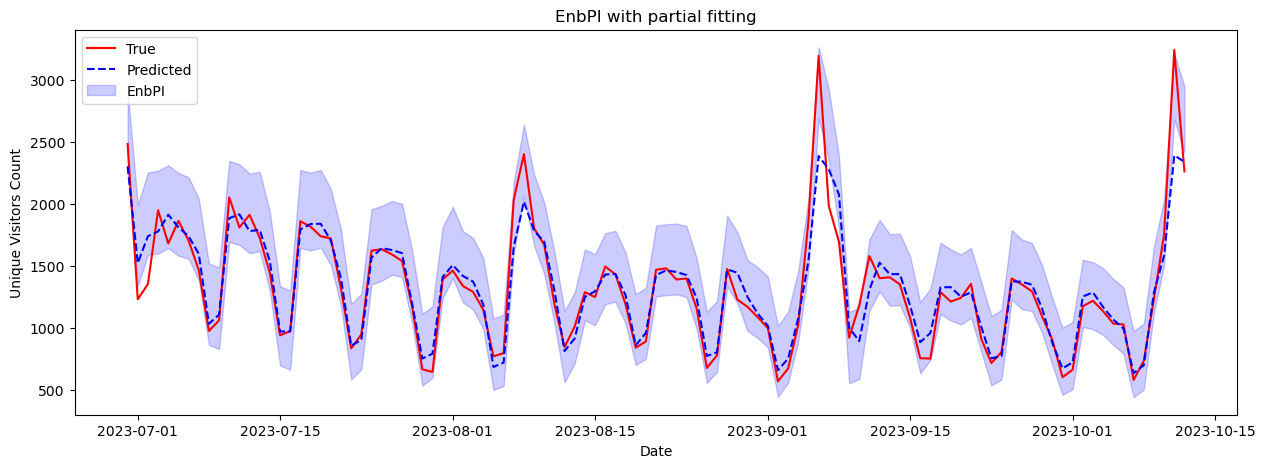

In [16]:
# enbpi with partial fit

mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=1
)

mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_pfit = np.zeros(y_pred_enbpi_npfit.shape)
y_pis_enbpi_pfit = np.zeros(y_pis_enbpi_npfit.shape)
y_pred_enbpi_pfit[:gap], y_pis_enbpi_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=True
)

for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_enbpi_pfit[step:step + gap],
        y_pis_enbpi_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )
    y_pis_enbpi_pfit[step:step + gap, :, :] = np.clip(
        y_pis_enbpi_pfit[step:step + gap, :, :], lower_clip_bound, upper_clip_bound
    )
# evaluation
coverage_enbpi_pfit = regression_coverage_score(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
width_enbpi_pfit = regression_mean_width_score(
    y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
cwc_enbpi_pfit = coverage_width_based(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0],
    eta=10,
    alpha=0.05
)
r2_enbpi_pfit = r2_score(y_test, y_pred_enbpi_pfit)

print(f"EnbPI with partial fitting")
print(f"Coverage: {coverage_enbpi_pfit}")
print(f"Width: {width_enbpi_pfit}")
print(f"CWC: {cwc_enbpi_pfit}")
print(f"R2 score: {r2_enbpi_pfit}")

# plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test.index, y_test, label="True", color="Red")
ax.plot(test.index, y_pred_enbpi_pfit, label="Predicted", color="blue", linestyle="--")
ax.fill_between(
    test.index,
    y_pis_enbpi_pfit[:, 0, 0],
    y_pis_enbpi_pfit[:, 1, 0],
    color="blue",
    alpha=0.2,
    label="EnbPI",
)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Unique Visitors Count")
ax.set_title("EnbPI with partial fitting")
plt.show()


ACI without partial fitting
Coverage: 0.9428571428571428
Width: 704.2152902277865
CWC: 0.7357746437898328
R2 score: 0.8800241186904116


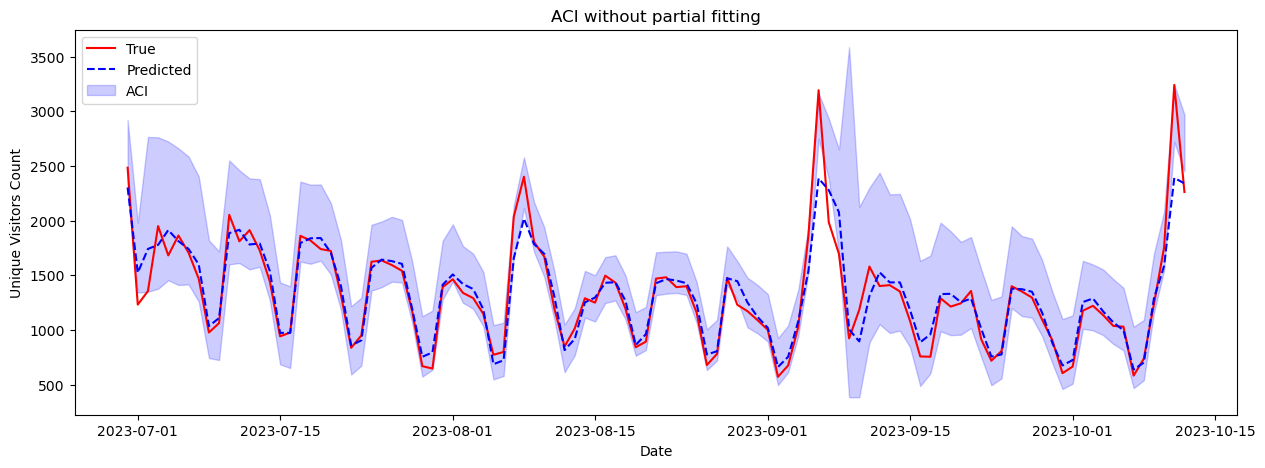

In [17]:
# For ACI without partial fitting
mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs=1
)

mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_npfit = np.zeros(y_pred_enbpi_npfit.shape)
y_pis_aci_npfit = np.zeros(y_pis_enbpi_npfit.shape)
y_pred_aci_npfit[:gap], y_pis_aci_npfit[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=True
)

count = 0
for step in range(gap, len(X_test), gap):
    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma=0.05
    )
    (
        y_pred_aci_npfit[step:step + gap],
        y_pis_aci_npfit[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )

    y_pis_aci_npfit[step:step + gap, :, :] = np.clip(
        y_pis_aci_npfit[step:step + gap, :, :], lower_clip_bound, upper_clip_bound
    )

# evaluation
coverage_aci_npfit = regression_coverage_score(
    y_test, y_pis_aci_npfit[:, 0, 0], y_pis_aci_npfit[:, 1, 0]
)
width_aci_npfit = regression_mean_width_score(
    y_pis_aci_npfit[:, 0, 0], y_pis_aci_npfit[:, 1, 0]
)
cwc_aci_npfit = coverage_width_based(
    y_test,
    y_pis_aci_npfit[:, 0, 0],
    y_pis_aci_npfit[:, 1, 0],
    eta=10,
    alpha=0.05
)
r2_aci_npfit = r2_score(y_test, y_pred_aci_npfit) 

print(f"ACI without partial fitting")
print(f"Coverage: {coverage_aci_npfit}")
print(f"Width: {width_aci_npfit}")
print(f"CWC: {cwc_aci_npfit}")
print(f"R2 score: {r2_aci_npfit}")

# plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test.index, y_test, label="True", color="Red")
ax.plot(test.index, y_pred_aci_npfit, label="Predicted", color="blue", linestyle="--")
ax.fill_between(
    test.index,
    y_pis_aci_npfit[:, 0, 0],
    y_pis_aci_npfit[:, 1, 0],
    color="blue",
    alpha=0.2,
    label="ACI",
)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Unique Visitors Count")
ax.set_title("ACI without partial fitting")
plt.show()

ACI with partial fitting
Coverage: 0.9333333333333333
Width: 632.9887004604378
CWC: 0.7628346361785215
R2 score: 0.8800241186904116


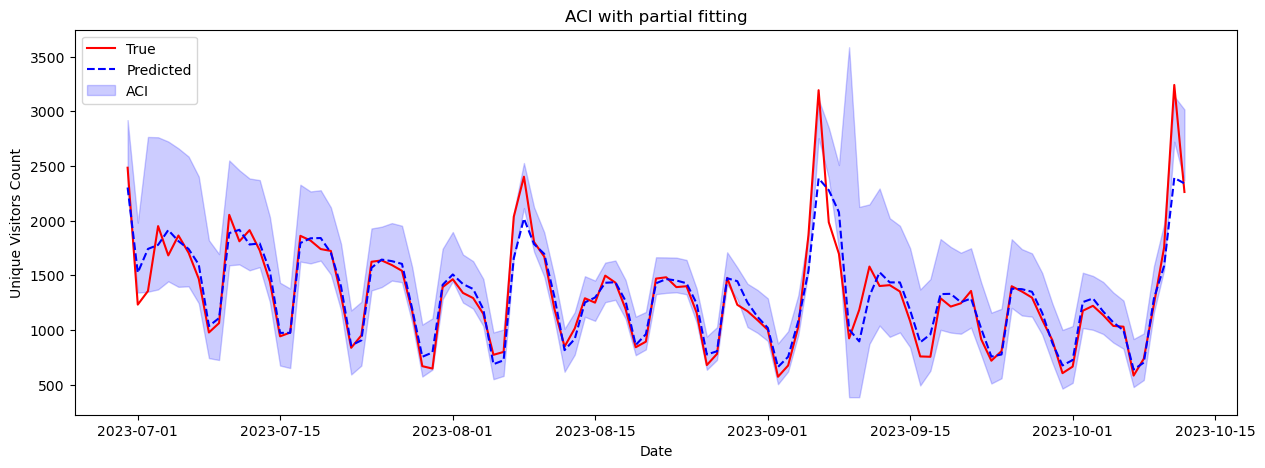

In [18]:
# For ACI with partial fit
mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs= 1
)

mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_pfit = np.zeros(y_pred_aci_npfit.shape)
y_pis_aci_pfit = np.zeros(y_pis_aci_npfit.shape)
y_pred_aci_pfit[:gap], y_pis_aci_pfit[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=True
)

for step in range(gap, len(X_test), gap):
    mapie_aci.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma=0.05
    )
    (
        y_pred_aci_pfit[step:step + gap],
        y_pis_aci_pfit[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )
    y_pis_aci_pfit[step:step + gap, :, :] = np.clip(
        y_pis_aci_pfit[step:step + gap, :, :], lower_clip_bound, upper_clip_bound
    )

coverage_aci_pfit = regression_coverage_score(
    y_test, y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0]
)
width_aci_pfit = regression_mean_width_score(
    y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0]
)
cwc_aci_pfit = coverage_width_based(
    y_test, y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0],
    eta=0.01,
    alpha=0.05
)
r2_aci_pfit = r2_score(y_test, y_pred_aci_pfit)

print(f"ACI with partial fitting")
print(f"Coverage: {coverage_aci_pfit}")
print(f"Width: {width_aci_pfit}")
print(f"CWC: {cwc_aci_pfit}")
print(f"R2 score: {r2_aci_pfit}")

# plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test.index, y_test, label="True", color="Red")
ax.plot(test.index, y_pred_aci_pfit, label="Predicted", color="blue", linestyle="--")
ax.fill_between(
    test.index,
    y_pis_aci_pfit[:, 0, 0],
    y_pis_aci_pfit[:, 1, 0],
    color="blue",
    alpha=0.2,
    label="ACI",
)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Unique Visitors Count")
ax.set_title("ACI with partial fitting")
plt.show()

